## SeqtoSeq using attention 

In [1]:
from fastai.text import *

In [2]:
path = Config().data_path()

In [3]:
path.ls()

[PosixPath('/home/ricky/.fastai/data/giga-fren.tgz.1'),
 PosixPath('/home/ricky/.fastai/data/oxford-iiit-pet'),
 PosixPath('/home/ricky/.fastai/data/mnist_png'),
 PosixPath('/home/ricky/.fastai/data/imdb'),
 PosixPath('/home/ricky/.fastai/data/mnist_png.tgz'),
 PosixPath('/home/ricky/.fastai/data/imdb_sample.tgz'),
 PosixPath('/home/ricky/.fastai/data/giga-fren'),
 PosixPath('/home/ricky/.fastai/data/imdb_sample'),
 PosixPath('/home/ricky/.fastai/data/oxford-iiit-pet.tgz'),
 PosixPath('/home/ricky/.fastai/data/giga-fren.tgz'),
 PosixPath('/home/ricky/.fastai/data/human_numbers.tgz'),
 PosixPath('/home/ricky/.fastai/data/imdb.tgz'),
 PosixPath('/home/ricky/.fastai/data/human_numbers')]

In [4]:
path = Config().data_path()/'giga-fren'

In [5]:
path.ls()

[PosixPath('/home/ricky/.fastai/data/giga-fren/models'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/cc.en.300.bin'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/questions_easy.csv'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/cc.fr.300.bin'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/data_save.pkl'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/home/ricky/.fastai/data/giga-fren/giga-fren.release2.fixed.fr')]

Routines that already implemented to create model and data

In [6]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0])],res_y[i,:len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [7]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [8]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [9]:
data = load_data(path)

In [10]:
model_path = Config().model_path()
model_path.ls()

[PosixPath('/home/ricky/.fastai/models/en_emb.pth'),
 PosixPath('/home/ricky/.fastai/models/wt103-fwd.tgz'),
 PosixPath('/home/ricky/.fastai/models/wt103-fwd'),
 PosixPath('/home/ricky/.fastai/models/fr_emb.pth')]

In [11]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

In [12]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [13]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

In [86]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [87]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [88]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [89]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [90]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

In [18]:
class TeacherForcing(LearnerCallback):
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

### Implementing attention 

In [81]:
class Seq2SeqRNN_attn(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl,self.pr_force = nl,nh,out_sl,1
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.emb_enc,self.emb_dec = emb_enc,emb_dec
        self.emb_sz_enc,self.emb_sz_dec = emb_enc.embedding_dim,emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25, 
                              batch_first=True, bidirectional=True)
        self.out_enc = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        
        self.gru_dec = nn.GRU(self.emb_sz_dec + 2*nh, self.emb_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.enc_att = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V =  self.init_param(self.emb_sz_dec)
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        #enc_out, hid = self.gru_enc(emb, 2*h) # think should remove 2
        enc_out, hid = self.gru_enc(emb, h) # think should remove 2
        
        #pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1,2,0,3).contiguous()
        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(0,2,1,3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2*self.nh)
        hid = self.out_enc(pre_hid)
        return hid,enc_out
    
    def decoder(self, dec_inp, hid, enc_att, enc_out):
        hid_att = self.hid_att(hid[-1])
        # we have put enc_out and hid through linear layers
        u = torch.tanh(enc_att + hid_att[:,None])
        # we want to learn the importance of each time step
        attn_wgts = F.softmax(u @ self.V, 1)
        # weighted average of enc_out (which is the output at every time step)
        ctx = (attn_wgts[...,None] * enc_out).sum(1)
        emb = self.emb_dec(dec_inp)
        # concatenate decoder embedding with context (we could have just
        # used the hidden state that came out of the decoder, if we weren't
        # using attention)
        outp, hid = self.gru_dec(torch.cat([emb, ctx], 1)[:,None], hid)
        outp = self.out(self.out_drop(outp[:,0]))
        return hid, outp
        
    def show(self, nm,v):
        if False: print(f"{nm}={v[nm].shape}")
        
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        hid,enc_out = self.encoder(bs, inp)
#        self.show("hid",vars())
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        enc_att = self.enc_att(enc_out)
        
        res = []
        for i in range(self.out_sl):
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(2*self.nl, bs, self.nh)
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

In [82]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

In [21]:
m = Seq2SeqRNN_attn(emb_enc, emb_dec, 256, 30)

In [22]:
xb, yb = next(iter(data.train_dl))

Looking step by step into the encoder

In [23]:
bs, sl = xb.size()
bs, sl

(64, 30)

In [24]:
bs, sl = xb.size()
h = m.initHidden(bs)
h.size()   # 2 states per layer, bi-directional

torch.Size([4, 64, 256])

In [25]:
bs, sl = xb.size()
h = m.initHidden(bs)
h.size()   # 2 states per layer, bi-directional  
emb_dec = m.emb_enc(xb.cpu())
emb_dec.shape

torch.Size([64, 30, 300])

lets try to understand the ordering of gru. When we use batch_first=False two tensors are returned (out, h_n) and their shapes are (seq_len, batch, num_directions * hidden_size) and (num_layers * num_directions, batch, hidden_size)

In [26]:
gru = nn.GRU(300, 256, num_layers=2, dropout=0.25, batch_first=False, bidirectional=True)
out, h_n = gru(torch.randn(30,64,300))
out.shape, h_n.shape

(torch.Size([30, 64, 512]), torch.Size([4, 64, 256]))

In [27]:
out.view(30, 64, 2, 256)[0, 0, 1, :10]

tensor([-0.1776, -0.1372, -0.3016, -0.0184, -0.0820, -0.1400, -0.2431, -0.3669,
        -0.0260, -0.2836], grad_fn=<SliceBackward>)

In [28]:
h_n.view(2, 2, 64, 256)[1, 1, 0, :10]

tensor([-0.1776, -0.1372, -0.3016, -0.0184, -0.0820, -0.1400, -0.2431, -0.3669,
        -0.0260, -0.2836], grad_fn=<SliceBackward>)

okay so this is quite hard to grasp, the words are concatenated in sequence so for out we index as first word (for bi-direcional it is the last output), first batch value, backward pass, first 10 values in hidden state.

for h_n we index by layer 1, backward pass, first batch value, first 10 values in hidden state.

Now lets find the correct ordering when batch_first=True

In [29]:
bs, sl = xb.size()
h = m.initHidden(bs)
h.size()   # 2 states per layer  
emb_dec = m.emb_enc(xb.cpu())
enc_out, hid = m.gru_enc(emb_dec, h) 
enc_out.shape, hid.shape

(torch.Size([64, 30, 512]), torch.Size([4, 64, 256]))

In [30]:
enc_out.view(64, 30, 2, 256)[0, 0, 1, :10]

tensor([-0.1768,  0.2498,  0.0201,  0.3203,  0.0501, -0.2893,  0.0793, -0.1212,
        -0.3139,  0.3171], grad_fn=<SliceBackward>)

In [31]:
hid.view(2, 2, 64, 256)[1, 1, 0, :10]

tensor([-0.1768,  0.2498,  0.0201,  0.3203,  0.0501, -0.2893,  0.0793, -0.1212,
        -0.3139,  0.3171], grad_fn=<SliceBackward>)

So again, we see that words are consistent but can cause confusion. Compare output backward hidden state from last layer.

In [32]:
np.allclose(enc_out.view(64, 30, 2, 256)[0, 0, 1], hid.view(2, 2, 64, 256)[1, 1, 0])

True

Compare the output of the foward output hidden state

In [33]:
np.allclose(enc_out.view(64, 30, 2, 256)[0, -1, 0], hid.view(2, 2, 64, 256)[1, 0, 0])

True

In [34]:
hid.numel(), 2*2*64*256

(65536, 65536)

we now are trying to reshape the correct outputs with in the bi-direcional case

In [35]:
# reshape to layer, batch, direction, hidden
#pre_hid_ = hid.view(2, 2, 64, 256).permute(1,2,0,3).contiguous()
pre_hid_ = hid.view(2, 2, 64, 256).permute(0,2,1,3).contiguous()
pre_hid_.shape

torch.Size([2, 64, 2, 256])

In [36]:
# output layer, first batch, forward
np.allclose(pre_hid_[1, 0, 0], hid.view(2, 2, 64, 256)[1, 0, 0])

True

In [37]:
# now flatten bidirectional vector (layer, batch, bi-hidden)
pre_hid_flat = pre_hid_.view(2, 64, 2*256)
pre_hid_flat.shape

torch.Size([2, 64, 512])

In [38]:
pre_hid_flat[1, 0].shape

torch.Size([512])

to check lets grab the output of each directional rnn and concat compare with our flatten array

In [39]:
left = hid.view(2, 2, 64, 256)[1, 0, 0]
right = hid.view(2, 2, 64, 256)[1, 1, 0]

np.allclose(pre_hid_flat[1,0], torch.cat([left, right], 0))

True

great its in the correct order

In [40]:
# finally multiply by dense matrix to french vector for each layer
out_enc = m.out_enc(pre_hid_flat)
out_enc.shape

torch.Size([2, 64, 300])

### Decorder 

Looking step by step into decoder

In [46]:
bs, sl = xb.size()
hid, enc_out = m.encoder(bs, xb.cpu())
hid.shape, enc_out.shape # is the flatten hidden state dense to embedding

(torch.Size([2, 64, 300]), torch.Size([64, 30, 512]))

In [47]:
dec_inp = xb.cpu().new_zeros(bs).long() + m.bos_idx
dec_inp.shape

torch.Size([64])

In [43]:
m.enc_att

Linear(in_features=512, out_features=300, bias=False)

In [44]:
enc_att = m.enc_att(enc_out) # enc_out is for every batch every word bi-direction hidden state
enc_att.shape

torch.Size([64, 30, 300])

lets just do one step in the decorder network

In [50]:
# grab output vector
np.allclose(h[-1], h[1])

True

In [54]:
# not sure why you need another dense layer?
hid_att = m.hid_att(hid[-1])
hid_att.shape, hid_att[:, None].shape

(torch.Size([64, 300]), torch.Size([64, 1, 300]))

In [56]:
# so we add hidden vector to every output state
a = enc_att + hid_att[:,None]
a.shape

torch.Size([64, 30, 300])

In [57]:
m.V.shape

torch.Size([300])

In [58]:
# perform dot product to generate weights
u = torch.tanh(enc_att + hid_att[:, None])
(u @ m.V).shape

torch.Size([64, 30])

In [65]:
attn_wgts = F.softmax(u @ m.V, 1)
attn_wgts.shape, attn_wgts[0].sum(), attn_wgts[...,None].shape

(torch.Size([64, 30]),
 tensor(1.0000, grad_fn=<SumBackward0>),
 torch.Size([64, 30, 1]))

In [68]:
# now perform the weighted avergae, multiply weight at each word then sum in the word
# axes
ctx = (attn_wgts[...,None] * enc_out).sum(1)
ctx.shape

torch.Size([64, 512])

In [69]:
emb = m.emb_dec(dec_inp)
a = torch.cat([emb, ctx], 1)
a.shape, a[:,None].shape

(torch.Size([64, 812]), torch.Size([64, 1, 812]))

In [72]:
outp, hid = m.gru_dec(torch.cat([emb, ctx], 1)[:,None], hid)
outp.shape, hid.shape, outp[:,0].shape

(torch.Size([64, 1, 300]), torch.Size([2, 64, 300]), torch.Size([64, 300]))

In [73]:
outp = m.out(m.out_drop(outp[:,0]))
hid.shape, outp.shape

(torch.Size([2, 64, 300]), torch.Size([64, 8144]))

so we finally have the vector of probabilities for french words

In [79]:
outp.max(1)[1] # index of predicted word

tensor([   0, 5242, 2810, 6753, 8143, 5830,    0, 3807, 5727, 5724, 6842, 3807,
        6753, 7047, 6753, 6052,    0,    6, 6052,    0,    0, 2588,    0, 5727,
           0, 5242, 6540,    0,    0, 4896, 5724, 6405,    0,    0,    0,    0,
        8143, 6753, 3247, 7437, 7487, 4940, 6052, 5727, 4896,    0,    0, 5830,
        2588, 2588,    0, 6753,    0, 3240,    0,    0,    0, 4693, 6753, 5242,
        7437,    0, 5242, 6052])

### Train 

lets train the model

In [91]:
model = Seq2SeqRNN_attn(emb_enc, emb_dec, 256, 30)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
                callback_fns=partial(TeacherForcing, end_epoch=30))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


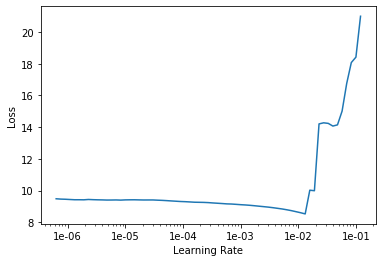

In [84]:
learn.lr_find()
learn.recorder.plot()

In [92]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.561432,4.271276,0.431707,0.253677,01:11
1,2.231420,3.530648,0.570698,0.334106,01:04
2,1.950797,2.987753,0.604998,0.341023,01:04
3,1.808132,3.771054,0.503009,0.399898,01:02
4,1.665941,3.475111,0.529311,0.405679,01:03
5,1.577948,3.763448,0.498438,0.425592,01:01
6,1.550794,3.409750,0.514386,0.434401,01:01
7,1.565027,3.716606,0.492722,0.431281,01:01
8,1.376277,3.712253,0.494533,0.433335,01:02
9,1.328058,3.657451,0.490790,0.433772,01:01
